In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as  yf
import math
from ta import add_all_ta_features
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from statsmodels.tsa.stattools import adfuller
import pyfolio as pf

import warnings
warnings.filterwarnings('ignore')

/home/josgt/anaconda3/envs/quantinsti/lib/python3.12/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
def my_bisection(f, a, b, tol, pi, payoff, lambda_risk): 
    # approximates a root, R, of f bounded 
    # by a and b to within tolerance 
    # | f(m) | < tol with m the midpoint 
    # between a and b Recursive implementation
    
    # check if a and b bound a root
    if np.sign(f(a, pi, payoff, lambda_risk)) == np.sign(f(b, pi, payoff, lambda_risk)):
        raise Exception("The scalars a and b do not bound a root")
        
    # get midpoint
    m = (a + b)/2
    
    if np.abs(f(m, pi, payoff, lambda_risk)) < tol:
        # stopping condition, report m as root
        return m
    elif np.sign(f(a, pi, payoff, lambda_risk)) == np.sign(f(m, pi, payoff, lambda_risk)):
        # case where m is an improvement on a. 
        # Make recursive call with a = m
        return my_bisection(f, m, b, tol, pi, payoff, lambda_risk)
    elif np.sign(f(b, pi, payoff, lambda_risk)) == np.sign(f(m, pi, payoff, lambda_risk)):
        # case where m is an improvement on b. 
        # Make recursive call with b = m
        return my_bisection(f, a, m, tol, pi, payoff, lambda_risk)

In [3]:
# Define function to find the risk-constraint value
def find_constraint_value(b, pi, payoff, lambda_risk):
    return pi*(b*payoff+(1-b))**(-lambda_risk) + (1-pi)*(1-b)**(-lambda_risk)-1

# Define the 2 Kelly functions inside of one
def kelly_functions(pi, payoff, lambda_risk=None):
    # If there is no lambda risk
    if lambda_risk is None:
        # Define the basic Kelly criterion percentage value
        return pi - (1-pi)/payoff
    # If there is lambda risk
    else:
        # Set the Kelly fraction
        b = (pi*payoff  - 1)/(payoff - 1)
        # Set the risk-constraint value
        value =  find_constraint_value(b, pi, payoff, lambda_risk)
        # If b is nan
        if math.isnan(b):
            # Return is zero
            return 0.0
        # If b is less than zero
        elif b < 0:
            # Return zero
            return 0.0
        # If value is less than one
        elif value <= 0:
            # Return b
            return b
        # Else
        else:
            # Find the optimal Kelly fraction with the bisection algorithm
            try:
                return my_bisection(find_constraint_value, 0.01, 0.99, 1, pi, payoff, lambda_risk)
            except:
                return 0.0

In [4]:
# Download the Apple stock data
data = yf.download('AAPL', start='1990-01-01', end='2024-11-11', auto_adjust=True)
# Create the percentage returns
data['returns'] = data['Close'].pct_change()
# Output the data
data.to_csv('data.csv')

[*********************100%***********************]  1 of 1 completed


In [5]:
data = pd.read_csv('data.csv', index_col=0, parse_dates=True)
data

,Open,High,Low,Close,Volume,returns
Date,,,,,,
1990-01-02,0.248055,0.263889,0.246296,0.262129,183198400,NaN
1990-01-03,0.267408,0.267408,0.263889,0.263889,207995200,0.006711
1990-01-04,0.269167,0.272685,0.262129,0.264769,221513600,0.003336
1990-01-05,0.265649,0.269167,0.260370,0.265649,123312000,0.003322
1990-01-08,0.263889,0.267408,0.260370,0.267408,101572800,0.006622
...,...,...,...,...,...,...
2024-11-04,220.747138,222.545148,219.468546,221.766006,44944500,-0.004038
2024-11-05,221.556241,223.703872,220.896963,223.204422,28111300,0.006486
2024-11-06,222.365355,225.821559,220.946918,222.475235,54561100,-0.003267


In [6]:
# Get the input features based on the available technical indicators
features = add_all_ta_features(data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True).drop(\
                                ["Open", "High", "Low", "Close", "Volume", "returns"], axis=1)

# Set 2 lists to save indicators names as needed
indicators_to_become_stationary = list()
indicators_to_drop = list()

# Loop to check for each indicator's stationarity
for indicator in features.columns.tolist():
    # Get the Augmented-Dickey Fuller p-value
    pvalue = adfuller(features[indicator].dropna(), regression='c', autolag='AIC')[1]
    # If p-value is higher than 5%
    if pvalue > 0.05:
        # Save the indicator name to become it stationary later
        indicators_to_become_stationary.append(indicator)
    # I p-value is NaN
    elif np.isnan(pvalue):
        # Save the indicator name to drop it later
        indicators_to_drop.append(indicator)

# Make the respective indicators stationary
features[indicators_to_become_stationary] = features[indicators_to_become_stationary].pct_change()
# Drop the respective indicators which p-values where NaN
features.drop(indicators_to_drop, axis=1, inplace=True)

# Concatenate the input features with the previous dataframe
data = pd.concat([data, features], axis=1)
# Set the features columns' names as a list
features = features.columns.tolist()

In [7]:
# Set the prediction feature
data['y'] = np.where(data['returns'].shift(-1)>=0, 1.0, 0.0)
# Set the signal column
data['signal'] = 0.0
# Set the train_signal column
data['train_signal'] = 0.0
# Set the basic Kelly criterion position size column
data['pos_size'] = 0.0
# Drop the NaN values
data.dropna(inplace=True)
# Output the data
data

,Open,High,Low,Close,Volume,returns,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,y,signal,train_signal,pos_size
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-15,0.242778,0.251574,0.241019,0.241019,161739200,-0.007246,-4.576558e+08,350840000,-0.274351,-3.634299e+05,...,-2.643587,-0.024770,-0.013017,-0.724625,-0.727264,0.090910,1.0,0.0,0.0,0.0
1990-01-16,0.235741,0.246296,0.230463,0.245417,214244800,0.018247,-2.672149e+08,565084800,-0.141956,-1.769093e+05,...,-2.196340,1.788987,0.000172,1.824687,1.808240,-0.208323,0.0,0.0,0.0,0.0
1990-01-17,0.244537,0.244537,0.232222,0.233981,197299200,-0.046595,-4.081469e+08,367785600,-0.196254,-4.739440e+05,...,-1.644061,2.209115,-0.009526,-4.659497,-4.771546,0.684216,0.0,0.0,0.0,0.0
1990-01-18,0.232222,0.235741,0.226944,0.227824,273291200,-0.026314,-6.267348e+08,94494400,-0.266359,-6.466184e+05,...,-0.408184,4.943509,-0.015422,-2.631423,-2.666664,0.218738,1.0,0.0,0.0,0.0
1990-01-19,0.237500,0.242778,0.235741,0.241019,265137600,0.057915,-4.941501e+08,359632000,-0.188743,-5.448340e+04,...,1.080807,5.955966,0.000745,5.791470,5.629971,-0.384619,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-04,220.747138,222.545148,219.468546,221.766006,44944500,-0.004038,9.671776e+10,185944889800,0.105390,-6.936809e+07,...,-4.057323,5.469578,-0.007166,-0.403753,-0.404571,-0.004042,1.0,0.0,0.0,0.0
2024-11-05,221.556241,223.703872,220.896963,223.204422,28111300,0.006486,9.673586e+10,185973001100,0.095208,-5.368183e+07,...,-3.645079,1.648975,-0.002889,0.648619,0.646524,0.006494,0.0,0.0,0.0,0.0
2024-11-06,222.365355,225.821559,220.946918,222.475235,54561100,-0.003267,9.671551e+10,185918440000,0.032864,-5.169661e+07,...,-2.912604,2.929901,-0.002095,-0.326690,-0.327225,-0.003271,1.0,0.0,0.0,0.0


In [8]:
# Set the random seed
np.random.seed(100)
# Set the window to be used to subset the data
window = 250
# Set the test span to be used to split the data to fit the ML model
test_span = 60
# Set the lambda risk for the risk-constraint Kelly criterion
lambda_risk = 5.7
# Set the initial payoff
payoff = 0.0
# Initial index number to test the model
initial_iloc = data.index.get_loc(data[data.index.year>=2016].index[0])

In [9]:
# Set the for loop 
for t in range(initial_iloc,len(data.index)):
    # Set the data sample
    data_sample = data.iloc[(t-window):t,:].copy()

    # Set the X train data
    X = data_sample.loc[data_sample.index[:(-1-test_span)],features]
    # Set the X test data
    X_test = data_sample.loc[data_sample.index[(-test_span):],features]
    # Set the prediction feature train data
    y = data_sample.loc[data_sample.index[:(-1-test_span)],'y']

    # Set the ML model
    #clf = RandomForestClassifier(n_estimators=5, max_depth=2, max_features=1.0, random_state=100)
    clf = LinearSVC(random_state=100)
    # Fit the model
    clf.fit(X, y)

    # Compute the train-sample predictions
    data_sample.loc[data_sample.index[:(-1-test_span)],'train_signal'] = clf.predict(X)

    # Compute the train-data strategy returns
    data_sample['train_stra_returns'] = data_sample['returns'] * data_sample['train_signal'].shift(1)

    # Set the strategy mean positive return
    pos_avg = data_sample[data_sample['train_stra_returns']>0]['train_stra_returns'].iloc[(-test_span):].mean()
    # Set the strategy mean negative return
    neg_avg = abs(data_sample[data_sample['train_stra_returns']<0]['train_stra_returns'].iloc[(-test_span):].mean())

    # Set the total number of positive returns
    pos_ret_num = len(data_sample[data_sample['train_stra_returns']>0].index[(-test_span):])
    # Set the total number of negative returns
    neg_ret_num = len(data_sample[data_sample['train_stra_returns']<0].index[(-test_span):])

    # If the sum of both total number of positive and negative returns is higher than zero
    if (pos_ret_num + neg_ret_num) > 0:
        # Compute the winning probability
        pi = pos_ret_num / (pos_ret_num + neg_ret_num)
        # If the mean negative return is higher than zero
        if neg_avg > 0:
            # Compute the payoff
            payoff = (1+pos_avg/neg_avg)
            # Compute the risk-constraint Kelly fraction
            data.loc[data.index[t],'rc_kelly_pos_size'] = np.round(kelly_functions(pi, payoff, lambda_risk),3)
            # Set the basic Kelly fraction
            data.loc[data.index[t],'kelly_pos_size'] = np.round(kelly_functions(pi, payoff),3)
        # If the mean negative return is equal or lower than zero
        else:
            # Set the risk-constraint Kelly fraction as zero
            data.loc[data.index[t],'rc_kelly_pos_size'] = 0
            # Set the basic Kelly fraction
            data.loc[data.index[t],'kelly_pos_size'] = 0
    # If the sum of both the total number of positive and negative returns is equal or lower than zero
    else:
        # Set the risk-constraint Kelly fraction as zero
        data.loc[data.index[t],'rc_kelly_pos_size'] = 0
        # Set the basic Kelly fraction
        data.loc[data.index[t],'kelly_pos_size'] = 0

    # Set the new X train data
    X = data_sample.loc[data_sample.index[:-1],features]
    # Set the new X test data
    X_test = data_sample.loc[data_sample.index[-1:],features]
    # Set the new train-data prediction feature
    y = data_sample.loc[data_sample.index[:-1],'y']

    # Create the ML object
    #clf = RandomForestClassifier(n_estimators=5, max_depth=2, max_features=1.0, random_state=100)
    clf = LinearSVC(random_state=100)
    # Fit the model
    clf.fit(X, y)
    # Predict the signal and save it
    data.loc[data.index[t],'signal'] = clf.predict(X_test)    

In [10]:
# Subset the data to create the strategy returns
results = data.iloc[initial_iloc:,:]
# Create the Buy-and-Hold cumulative returns
results['bh_cum_rets'] = (1+results['returns']).cumprod()
# Create the risk-constraint-Kelly-based strategy returns
results['rc_kelly_rets'] = results['returns'] * results['signal'].shift() * results['rc_kelly_pos_size'].shift()
# Create the risk-constraint-Kelly-based strategy cumulative returns
results['rc_kelly_cum_rets'] = (1+results['rc_kelly_rets']).cumprod()
# Create the basic-Kelly-based strategy returns
results['kelly_rets'] = results['returns'] * results['signal'].shift() * results['kelly_pos_size'].shift()
# Create the basic-Kelly-based strategy cumulative returns
results['kelly_cum_rets'] = (1+results['kelly_rets']).cumprod()
# Create a moving average signal
results['mov_avg_signal'] = np.where(results['bh_cum_rets'] > results['bh_cum_rets'].rolling(19).mean(),1,0)
# Create the improved risk-constraint-Kelly-based strategy returns
results['rc_kelly_rets_imp'] = results['rc_kelly_rets'] * results['mov_avg_signal'].shift()
# Create the improved basic-Kelly-based strategy returns
results['kelly_rets_imp'] = results['kelly_rets'] * results['mov_avg_signal'].shift()
# Create the improved risk-constraint-Kelly-based strategy cumulative returns
results['rc_kelly_cum_rets_imp'] = (1+results['rc_kelly_rets_imp']).cumprod()
# Create the improved basic-Kelly-based strategy cumulative returns
results['kelly_cum_rets_imp'] = (1+results['kelly_rets_imp']).cumprod()

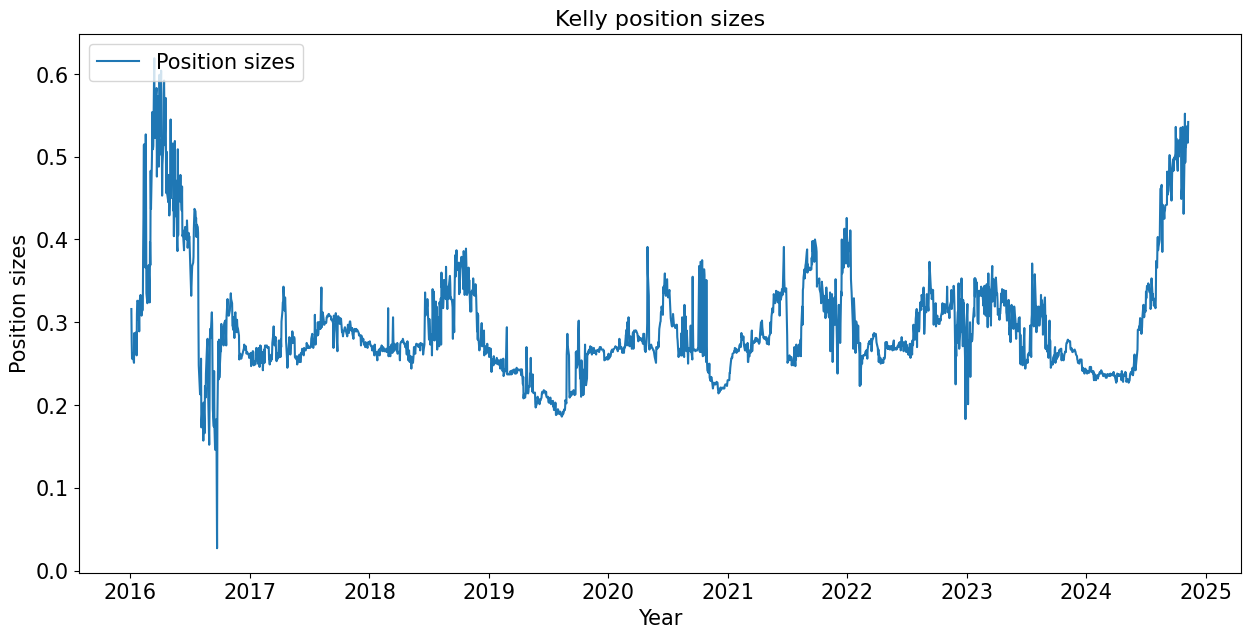

In [11]:
# Set the figure size
plt.figure(figsize=(15,7))

# Plot both the Buy-and-hold and the strategies' cumulative returns
plt.plot(results.index, results['kelly_pos_size'], label = "Position sizes")

# Set the title of the graph
plt.title('Kelly position sizes', fontsize=16)

# Set the x- and y- axis labels and ticks sizes
plt.xlabel('Year', fontsize=15)
plt.ylabel('Position sizes', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Set the plot legend location
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))

plt.savefig('Figures/basic-kelly-position-size.png', bbox_inches='tight')

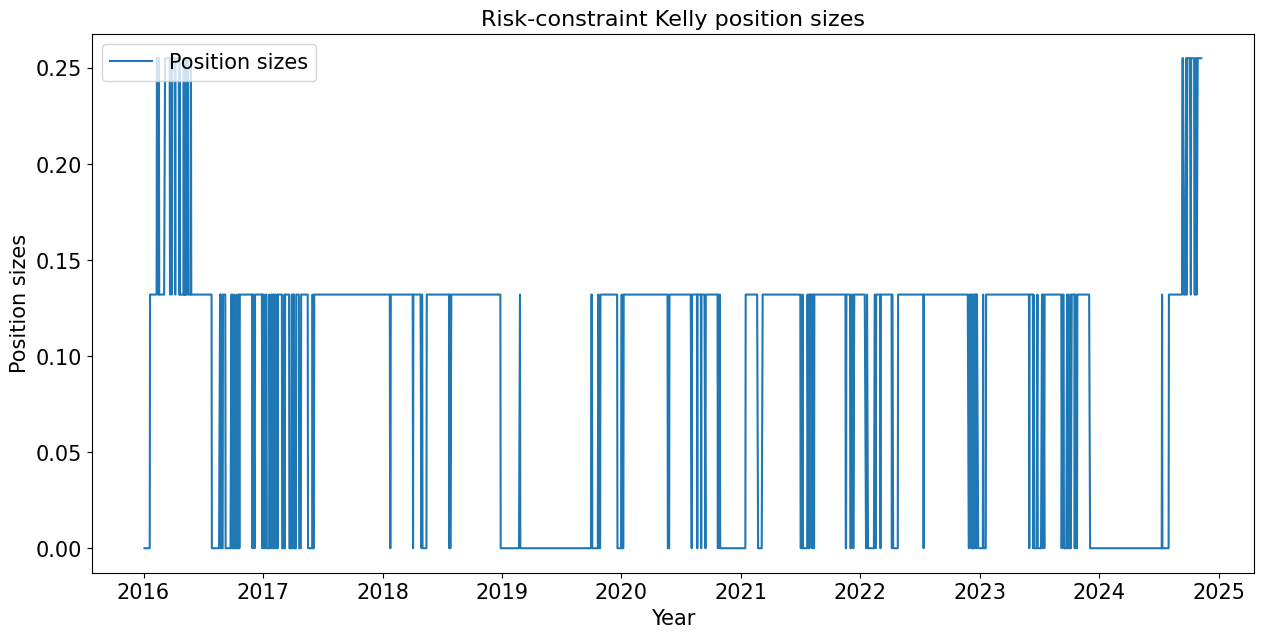

In [12]:
# Set the figure size
plt.figure(figsize=(15,7))

# Plot both the Buy-and-hold and the strategies' cumulative returns
plt.plot(results.index, results['rc_kelly_pos_size'], label = "Position sizes")

# Set the title of the graph
plt.title('Risk-constraint Kelly position sizes', fontsize=16)

# Set the x- and y- axis labels and ticks sizes
plt.xlabel('Year', fontsize=15)
plt.ylabel('Position sizes', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Set the plot legend location
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))

plt.savefig('Figures/rc-kelly-position-size.png', bbox_inches='tight')

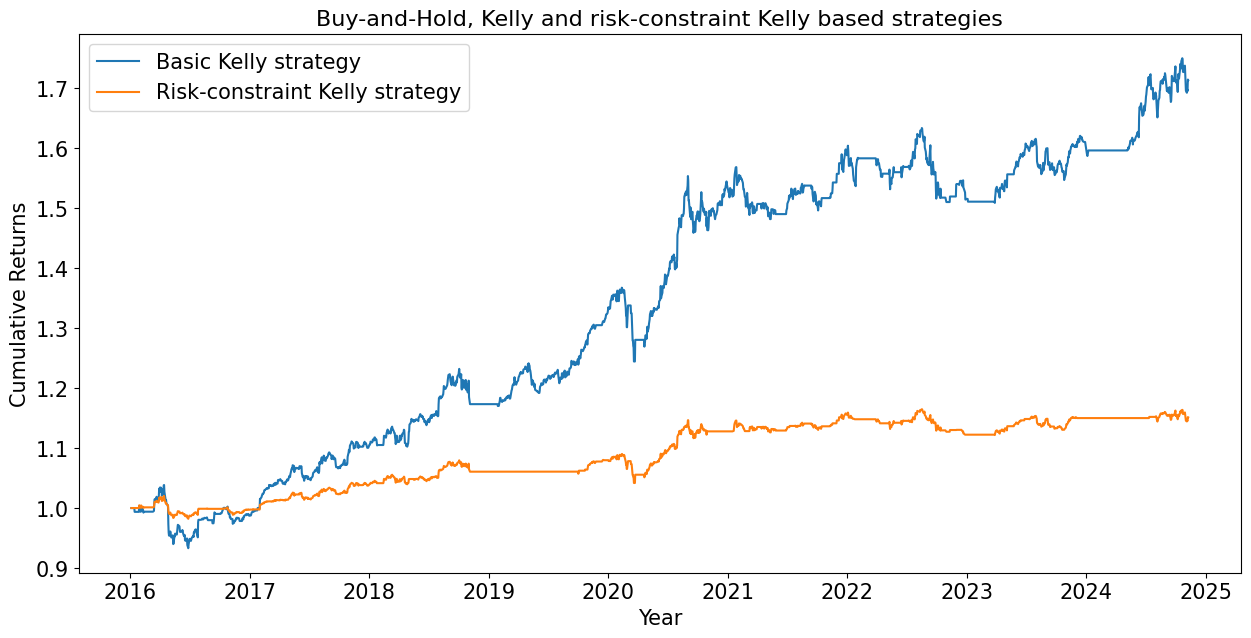

In [13]:
# Set the figure size
plt.figure(figsize=(15,7))

# Plot both the Buy-and-hold and the strategies' cumulative returns
plt.plot(results.index, results['kelly_cum_rets'], label = "Basic Kelly strategy")
plt.plot(results.index, results['rc_kelly_cum_rets'], label = "Risk-constraint Kelly strategy")

# Set the title of the graph
plt.title('Buy-and-Hold, Kelly and risk-constraint Kelly based strategies', fontsize=16)

# Set the x- and y- axis labels and ticks sizes
plt.xlabel('Year', fontsize=15)
plt.ylabel('Cumulative Returns', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Set the plot legend location
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))

plt.savefig('Figures/strategies-cum-returns.png', bbox_inches='tight')

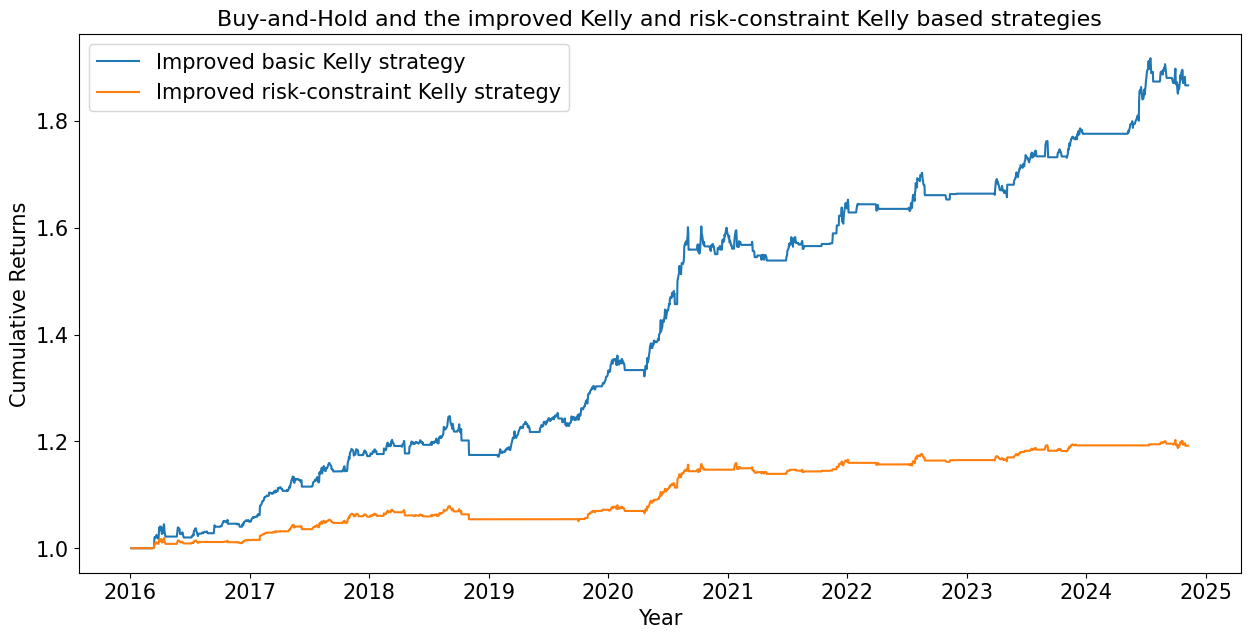

In [14]:
# Set the figure size
plt.figure(figsize=(15,7))

# Plot both the Buy-and-hold and the improved strategies' cumulative returns
plt.plot(results.index, results['kelly_cum_rets_imp'], label = "Improved basic Kelly strategy")
plt.plot(results.index, results['rc_kelly_cum_rets_imp'], label = "Improved risk-constraint Kelly strategy")

# Set the title of the graph
plt.title('Buy-and-Hold and the improved Kelly and risk-constraint Kelly based strategies', fontsize=16)

# Set the x- and y- axis labels and ticks sizes
plt.xlabel('Year', fontsize=15)
plt.ylabel('Cumulative Returns', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Set the plot legend location
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))

plt.savefig('Figures/improved-strategies-cum-returns.png', bbox_inches='tight')